# Задача 5. Обучение без учителя
## Задача

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
-  Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib

# устанавливаем точность чисел с плавающей точкой
%precision % .4f

import warnings

warnings.filterwarnings('ignore')  # отключаем предупреждения
dataset_path = pathlib.Path().resolve().parent / "datasets" / "self_data" / "task06_data.csv"

# Датасет
Будет использован [Датасет](https://www.kaggle.com/datasets/ashishguptajiit/handwritten-az), который состоит из 372038 изображений 28x28.

Первая колонка содержит в себе букву, которая нарисована.
- *0* A
- *1* B
- ...
- *25* Z

Так как мой компьютер не потянет столько значений, то я с помощью скрипта отобрал по 500 изображений каждой буквы

In [27]:
df = pd.read_csv(dataset_path)

# 1.EDA

In [28]:
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.598,0.599,0.600,0.601,0.602,0.603,0.604,0.605,0.606,0.607
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Заменим названия колонок на более понятные

In [29]:
rename_dict = {}
i = 0

for column in df:
    rename_dict[column] = f"pixel{i}"
    i += 1

df.rename(columns=rename_dict, inplace=True)
df.rename(columns={"pixel0": "label"}, inplace=True)

In [30]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 644.1 KB


In [32]:
labels = df["label"]
labels.unique()

array([0])

In [33]:
labels.value_counts()

label
0    105
Name: count, dtype: int64

In [34]:
df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [35]:
df.drop(columns=["label"], inplace=True)

# PCA & t-SNE

In [36]:
%%time
from sklearn.decomposition import PCA
pca = PCA()

pca_res = pca.fit_transform(df)

CPU times: user 13.2 ms, sys: 11 ms, total: 24.2 ms
Wall time: 16.2 ms


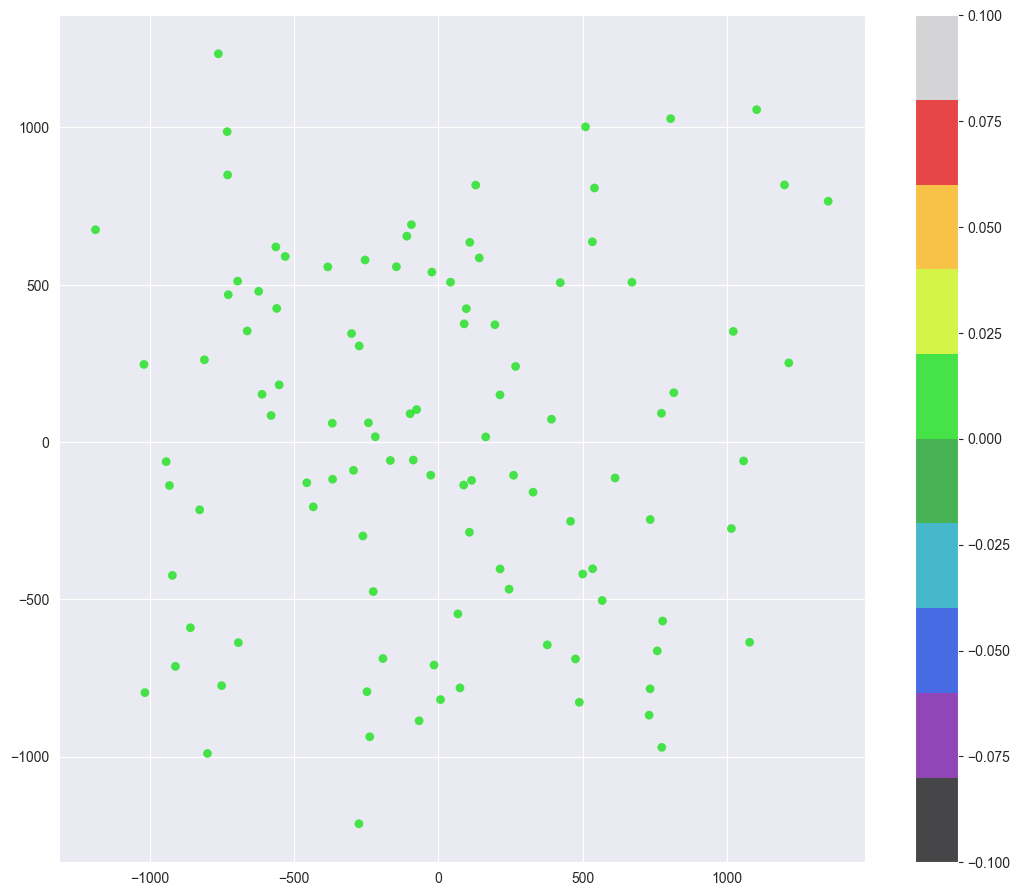

In [37]:
plt.figure(figsize=(13, 11))
plt.scatter(pca_res[:, 0], pca_res[:, 1], c=labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

In [38]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(df)

CPU times: user 1.4 s, sys: 502 ms, total: 1.9 s
Wall time: 285 ms


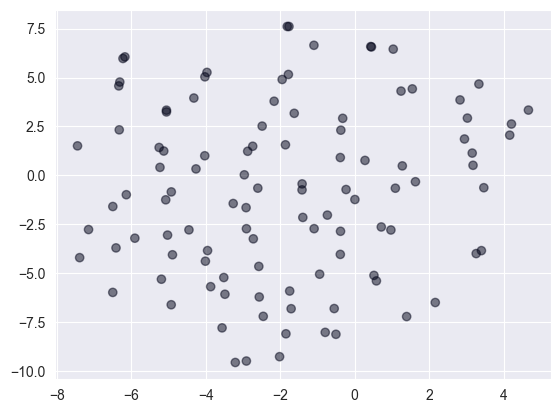

In [39]:
plt.scatter(tsne[:,0], tsne[:,1], c=labels, alpha=0.5);

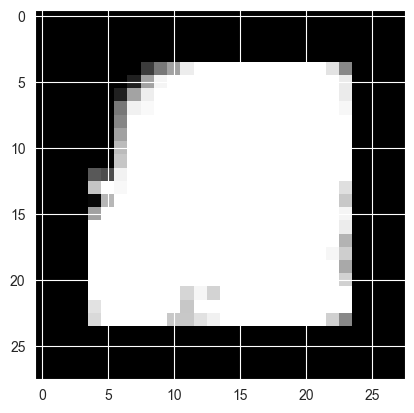

In [40]:
plt.imshow(df.max().values.reshape([28, 28]), cmap="gray");

Видим, что очень много неиспользумых пикселей
Выясним, сколько из пикселей содержат в себе наибольшую часть информации


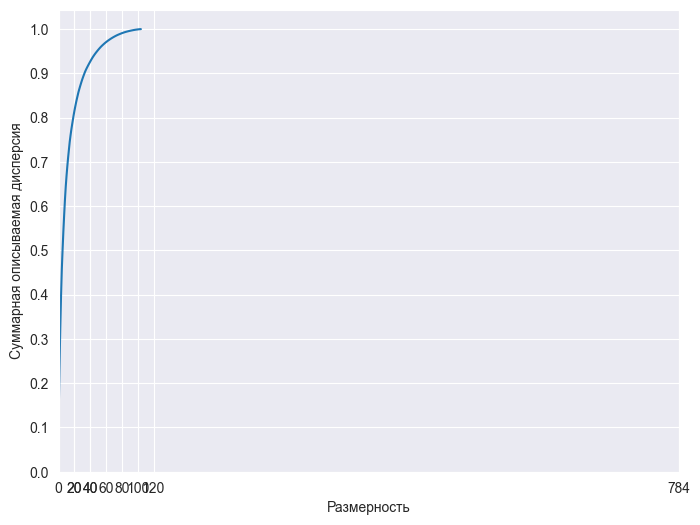

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная описываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 20, 40, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Уже при размерности 40, можно описать 80% дисперсии.

# Реализации алгоритма

In [42]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted

class SelfWritedKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

Используем *ARI*, *AMI*, *FMI* в качестве метрик, так как мы знаем ответы для данных

In [43]:
%%time
xs = [df, *(PCA(n_components=i).fit_transform(df) for i in [20, 50, 100, 105])]

CPU times: user 27.2 ms, sys: 9.29 ms, total: 36.4 ms
Wall time: 30.8 ms


In [44]:
import itertools, time
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import clone

def train(est, params):
    params_combs = [
        dict(param) for param in
        itertools.product(*([(name, v) for v in vs] for (name, vs) in params.items()))
    ]

    results = []
    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for param in params_combs:
            e = clone(est).set_params(**param)
            start_time = time.perf_counter()
            pred = e.fit_predict(x)
            pred_time = (time.perf_counter() - start_time)

            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, pred_time, param

            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, pred_time, param

            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, pred_time, param

        res = {
            "cluster": est.__class__.__name__,
            "dimension": x.shape[1],
            "mean fit predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "best ari": best_ari[0],
            "best ami": best_ami[0],
            "best fmi": best_fmi[0]
        }

        print(res)
        results.append(res)



    path = pathlib.Path("train_res.csv")
    pd.DataFrame(results).to_csv(path, mode="a", header=not path.exists())

# Обучение

In [45]:
train(
    SelfWritedKMeans(n_clusters=10, random_state=0),
    params={}
)

{'cluster': 'SelfWritedKMeans', 'dimension': 784, 'mean fit predict time, s': np.float64(0.021406708983704448), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.31824841127969716)}
{'cluster': 'SelfWritedKMeans', 'dimension': 20, 'mean fit predict time, s': np.float64(0.0008474579954054207), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.31939732624843936)}
{'cluster': 'SelfWritedKMeans', 'dimension': 50, 'mean fit predict time, s': np.float64(0.001879249990452081), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.32054212320263425)}
{'cluster': 'SelfWritedKMeans', 'dimension': 100, 'mean fit predict time, s': np.float64(0.0015583329950459301), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.31824841127969716)}
{'cluster': 'SelfWritedKMeans', 'dimension': 105, 'mean fit predict time, s': np.float64(0.0020782089850399643), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.3182

In [46]:
from sklearn.cluster import KMeans

train(
    KMeans(n_clusters=10, n_init='auto', random_state=0),
    params={"algorithm": ["lloyd", "elkan"]}
)

{'cluster': 'KMeans', 'dimension': 784, 'mean fit predict time, s': np.float64(0.006869833014206961), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.3317729043687264)}
{'cluster': 'KMeans', 'dimension': 20, 'mean fit predict time, s': np.float64(0.001863333018263802), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.3112658781274409)}
{'cluster': 'KMeans', 'dimension': 50, 'mean fit predict time, s': np.float64(0.0017327920068055391), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.32054212320263425)}
{'cluster': 'KMeans', 'dimension': 100, 'mean fit predict time, s': np.float64(0.001625208999030292), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.3317729043687264)}
{'cluster': 'KMeans', 'dimension': 105, 'mean fit predict time, s': np.float64(0.001133375015342608), 'best ari': 0.0, 'best ami': np.float64(0.0), 'best fmi': np.float64(0.3317729043687264)}


In [47]:
from sklearn.cluster import DBSCAN

train(
    DBSCAN(n_jobs=4),
    params={
        "eps": [500, 600, 700],
        "min_samples": [40, 80, 120]
    }
)

{'cluster': 'DBSCAN', 'dimension': 784, 'mean fit predict time, s': np.float64(0.03232204099185765), 'best ari': 1.0, 'best ami': 1.0, 'best fmi': np.float64(1.0)}
{'cluster': 'DBSCAN', 'dimension': 20, 'mean fit predict time, s': np.float64(0.0011345839884597808), 'best ari': 1.0, 'best ami': 1.0, 'best fmi': np.float64(1.0)}
{'cluster': 'DBSCAN', 'dimension': 50, 'mean fit predict time, s': np.float64(0.0005794999888166785), 'best ari': 1.0, 'best ami': 1.0, 'best fmi': np.float64(1.0)}
{'cluster': 'DBSCAN', 'dimension': 100, 'mean fit predict time, s': np.float64(0.0007396670116577297), 'best ari': 1.0, 'best ami': 1.0, 'best fmi': np.float64(1.0)}
{'cluster': 'DBSCAN', 'dimension': 105, 'mean fit predict time, s': np.float64(0.0005555410170927644), 'best ari': 1.0, 'best ami': 1.0, 'best fmi': np.float64(1.0)}


# Результаты

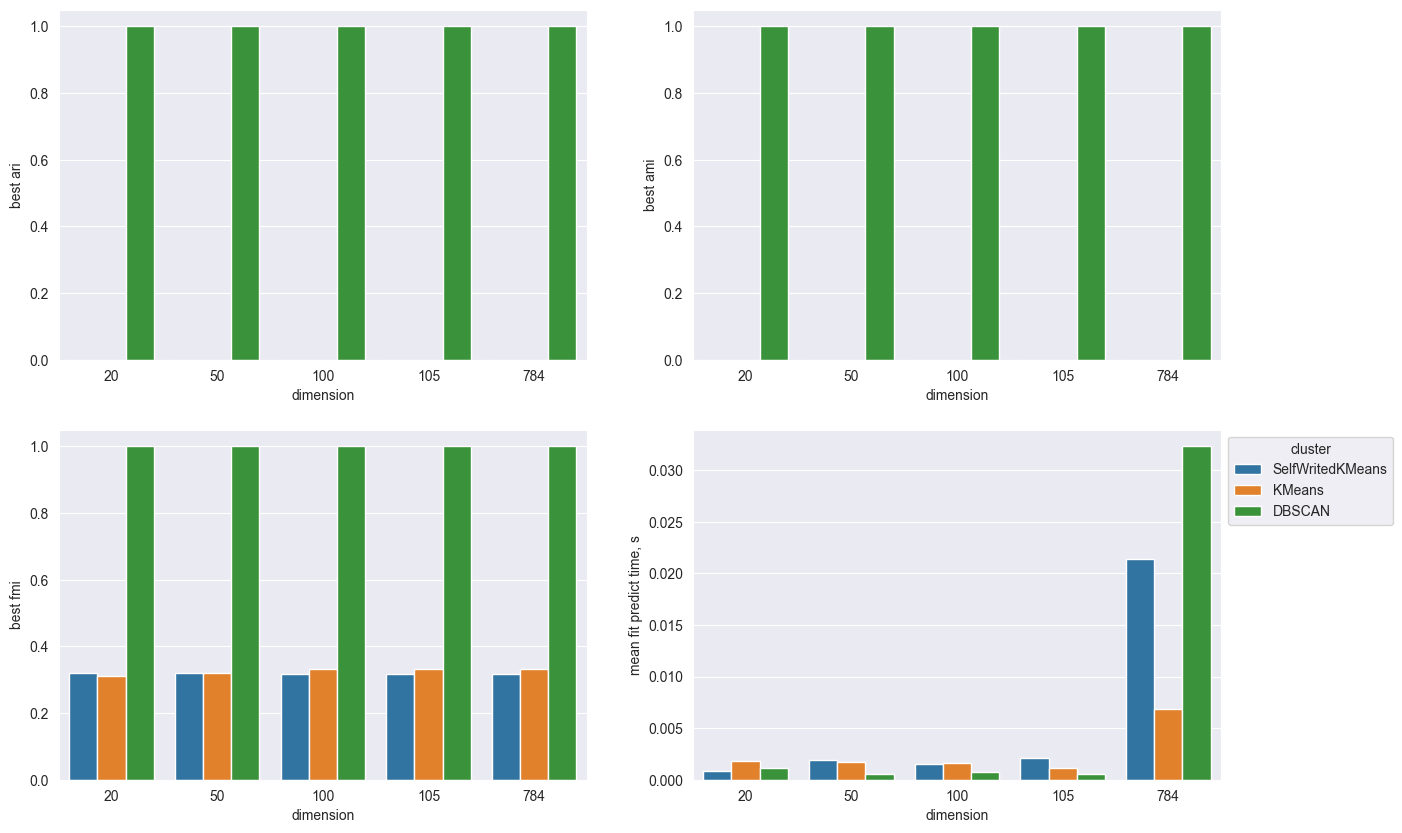

In [48]:
results = pd.read_csv(pathlib.Path("train_res.csv"))
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for y, ax in zip(
    ["best ari", "best ami", "best fmi", "mean fit predict time, s"], axs.flatten()
):
    sns.barplot(results, x="dimension", y=y, hue="cluster", ax=ax)
    if y == "mean fit predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()


# Итоги

По скорости самописный KMean проигрывает конкурентам, так как в нём нет параллельной работы. Качеством же он почти не уступает библиотечной. DBSCAN проигрывает обоим в качестве.